In [1]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [21]:
def extract_seed_pixels(image, seed_color):
    mask = np.all(image == seed_color, axis=-1)
    return image[mask]

def k_means_clustering(k, data_points):
    kmeans = KMeans(n_clusters=k, max_iter = 10, random_state=0)
    kmeans.fit(data_points)
    return kmeans.labels_, kmeans.cluster_centers_

def compute_likelihood(image, centroids, wk=0.1):
    height, width, _ = image.shape
    likelihoods = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            pixel_value = image[y, x]
            distances = np.linalg.norm(centroids - pixel_value, axis=1)
            cluster_likelihoods = np.exp(-distances * wk)
            likelihoods[y, x] = np.sum(cluster_likelihoods)
    return likelihoods

def segment_image(original_image_path, stroke_image_path):
    original_image = np.array(Image.open(original_image_path).convert('RGB'))
    stroke_image = np.array(Image.open(stroke_image_path).convert('RGB'))
    
    # colors for the foreground (red) and background (blue) seeds
    foreground_seed_color = [255, 0, 0]
    background_seed_color = [6, 0, 255]
    
    # Seed pixels for foreground and background
    foreground_seed_pixels = extract_seed_pixels(stroke_image, foreground_seed_color)
    background_seed_pixels = extract_seed_pixels(stroke_image, background_seed_color)
    
    
    # K-Means clustering
    N = 64  # Number of clusters
    _, foreground_centroids = k_means_clustering(N, foreground_seed_pixels)
    _, background_centroids = k_means_clustering(N, background_seed_pixels)
    
    # Likelihoods for the original image
    foreground_likelihoods = compute_likelihood(original_image, foreground_centroids)
    background_likelihoods = compute_likelihood(original_image, background_centroids)
    
    # Segment the image based on the likelihoods
    segmentation = foreground_likelihoods > background_likelihoods
    segmentation_mask = segmentation.astype(np.uint8) * 255
    
    # Apply the mask to create the segmented image
    segmented_image = np.zeros_like(original_image)
    for i in range(3):
        segmented_image[:, :, i] = original_image[:, :, i] * segmentation_mask
    
    # Save and display the segmented image
    segmented_image_pil = Image.fromarray(segmented_image)
    segmented_image_path = stroke_image_path.replace(' stroke', ' segmented ')
    segmented_image_pil.save(segmented_image_path)
    
    return segmented_image

# Process each stroke image
def process_image(original_image_path, stroke_image_paths):
    for stroke_image_path in stroke_image_paths:
        segmented_image = segment_image(original_image_path, stroke_image_path)

        # Display the results
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(Image.open(original_image_path)))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(segmented_image)
        plt.title(f'Segmented Image ({stroke_image_path})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

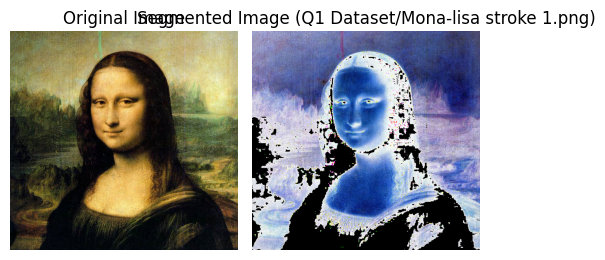

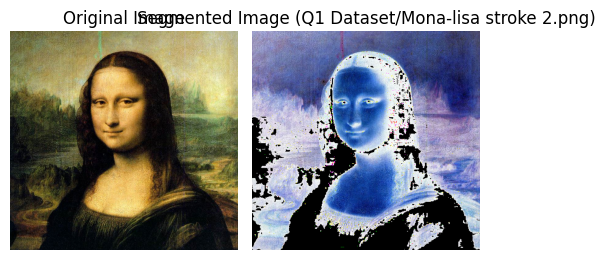

In [22]:
original_image_path = 'Q1 Dataset/Mona-lisa.png'  
stroke_image_paths = ['Q1 Dataset/Mona-lisa stroke 1.png', 'Q1 Dataset/Mona-lisa stroke 2.png']
process_image(original_image_path, stroke_image_paths)


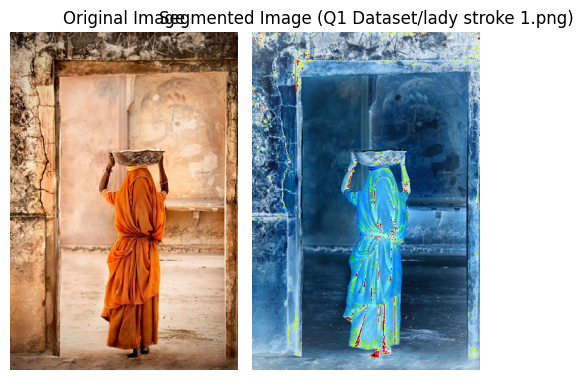

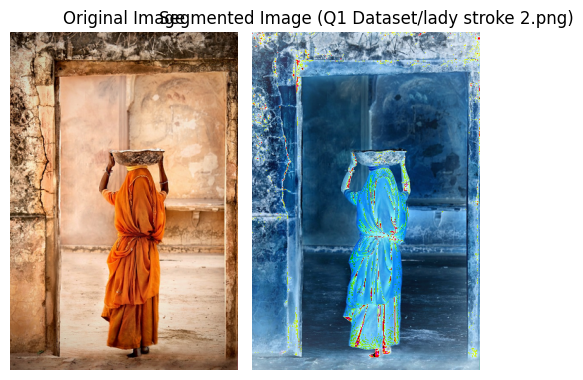

In [23]:
original_image_path = 'Q1 Dataset/lady.png'  
stroke_image_paths = ['Q1 Dataset/lady stroke 1.png', 'Q1 Dataset/lady stroke 2.png']
process_image(original_image_path, stroke_image_paths)

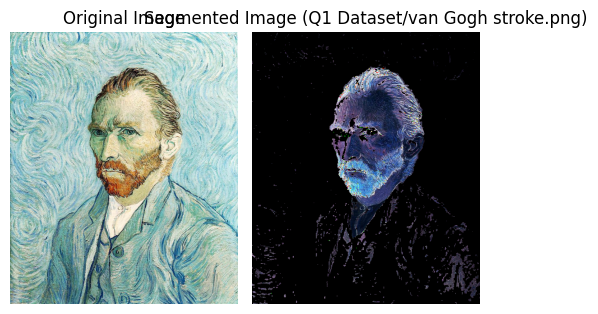

In [24]:
original_image_path = 'Q1 Dataset/van Gogh.png'  
stroke_image_paths = ['Q1 Dataset/van Gogh stroke.png']
process_image(original_image_path, stroke_image_paths)